In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
 
import re

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D

import importlib
importlib.reload(Cell3D)
import matplotlib.pyplot as plt
import seaborn as sns

import concurrent.futures
import tqdm
from sklearn.cluster import DBSCAN

from CHARMtools import spatialstat
import multiprocessing

from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy import stats
import copy

## Tune clsuter parameters

In [2]:
metadata = pd.read_csv('../1_createobj_embedding/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2]
metadata = metadata.query('celltype not in ["Inh_Unknown1","Inh_Unknown2","Ex_Unknown1","Ex_Unknown2"]').reset_index(drop=True)

In [3]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", type="allelic_resolved",
                      column_name="atac",keep_3prime=True)
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz", type="allelic_resolved",
                      column_name="ct" ,keep_3prime=True)
    cell.tdg["atac_random"] = cell.tdg["atac"].sample(frac=1,random_state=42).values
    cell.tdg["ct_random"] = cell.tdg["ct"].sample(frac=1,random_state=42).values

    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

    #cell.subset(query = 'atac > 0 or ct > 0 or atac_random > 0 or ct_random > 0',in_place=True)
    return cell

metadata_sample = metadata.sample(800,random_state=42)
with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata_sample['cellname'], [5000]*len(metadata_sample)), total=len(metadata_sample)))

100%|██████████| 800/800 [01:25<00:00,  9.39it/s]


In [4]:
from functools import partial

def _calc_spatial_autocorr(cell,query,count_name=None):
    np.random.seed(42)
    df = cell.get_data().query(query).copy()
    if count_name is not None:
        df[count_name] = df[count_name].astype(int)
        points = np.repeat(df[["x","y","z"]].values, df[count_name].values, axis=0)
    else:
        points = df[["x","y","z"]].values.copy()

    if points.shape[0] > 5000:
        points = points[np.random.choice(points.shape[0], 5000, replace=False), :]
        return spatialstat.spatial_autocorr_3d(points,dr=0.5,max_dist=10,Nsim=4)[0]
    else:
        return np.array([np.nan for i in range(20)])

with concurrent.futures.ProcessPoolExecutor(max_workers=128,mp_context=multiprocessing.get_context("fork")) as executor:
    cor_atac = list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='atac > 0',count_name='atac'),cells), total=len(cells)))
    cor_ct =   list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='ct > 0',count_name='ct'),cells), total=len(cells)))
    cor_all = list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='chrom_code > 0',count_name=None),cells), total=len(cells)))


100%|██████████| 800/800 [03:29<00:00,  3.81it/s]


In [5]:
def _post_process_cor(autocorr):
    autocorr = np.array(autocorr)
    autocorr[np.isinf(autocorr)] = np.nan
    means = np.nanmean(autocorr,axis=0)
    stderr = np.nanstd(autocorr,axis=0) / np.sqrt(np.sum(~np.isnan(autocorr), axis=0))
    return means, stderr

means_atac, stderr_atac = _post_process_cor(cor_atac)
means_ct, stderr_ct = _post_process_cor(cor_ct)
means_all, stderr_all = _post_process_cor(cor_all)

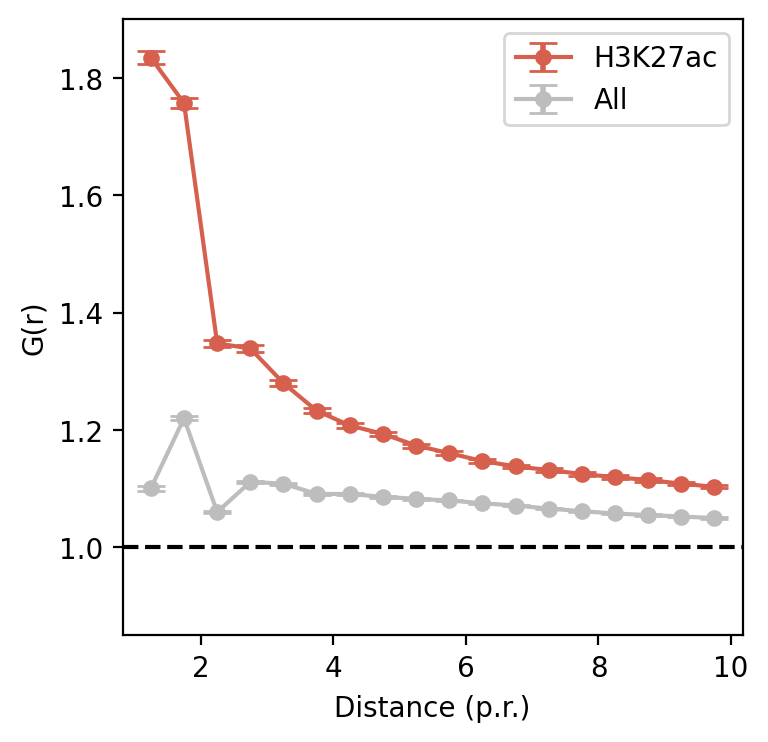

In [6]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))
r = np.arange(0.25, 10, 0.5)
start_i = 2

#plt.errorbar(r[start_i:],means_atac[start_i:],yerr=stderr_atac[start_i:],label='Accessibility',fmt='-o',ecolor='#0570b0',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#0570b0')
plt.errorbar(r[start_i:],means_ct[start_i:],yerr=stderr_ct[start_i:],label='H3K27ac',fmt='-o',ecolor='#d6604d',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#d6604d')
plt.errorbar(r[start_i:],means_all[start_i:],yerr=stderr_all[start_i:],label='All',fmt='-o',ecolor='#bdbdbd',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#bdbdbd')

plt.axhline(y=1, color='black', linestyle='--')

plt.legend()
#plt.xlim(0.75, 8)
plt.ylim(0.85, 1.9)
plt.xlabel('Distance (p.r.)')
plt.ylabel('G(r)')
# save pdf
plt.savefig('figures/spatial_autocorr_brain.pdf', bbox_inches='tight')

In [6]:
def _cluster_params_grid_search(cell):
    eps = [1.5,1.6,1.7,1.8,1.9]
    min_samples = [3,4,5,6,7,8,9,10,11,12]

    res = []
    for e in eps:
        for m in min_samples:
                cell.calc_3D_cluster(query = "atac > 0", eps = e, min_samples=m,cluster_name = "atac_cluster",random_seed=42)
                cell.calc_3D_cluster(query = "atac_random > 0", eps = e, min_samples=m,cluster_name = "atac_random_cluster",random_seed=42)
                cluster_number = cell.tdg["atac_cluster"].nunique() -1 
                cluster_number_random = cell.tdg["atac_random_cluster"].nunique() -1
                in_cluster_frags_number = cell.tdg.query('atac > 0 & atac_cluster != "-1"').shape[0]
                in_cluster_frags_number_random = cell.tdg.query('atac_random > 0 & atac_random_cluster != "-1"').shape[0]
                in_cluster_frags_ratio = in_cluster_frags_number / cell.tdg.query('atac > 0').shape[0]
                in_cluster_frags_ratio_random = in_cluster_frags_number_random / cell.tdg.query('atac_random > 0').shape[0]

                res.append([cell.cellname, e, m, cluster_number, in_cluster_frags_number, in_cluster_frags_ratio, cluster_number_random, in_cluster_frags_number_random, in_cluster_frags_ratio_random])
    return res

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    results = list(tqdm.tqdm(executor.map(_cluster_params_grid_search, cells), total=len(cells)))

100%|██████████| 800/800 [07:40<00:00,  1.74it/s]


In [7]:
cluster_stat_atac = pd.DataFrame([item for sublist in results for item in sublist])
cluster_stat_atac.columns = ["cellname", "eps", "min_samples", "cluster_number", "in_cluster_frags_number", "in_cluster_frags_ratio", "cluster_number_random", "in_cluster_frags_number_random", "in_cluster_frags_ratio_random"]

# group by eps, min_sample ,t-test on cluster_number and cluster_number_random
cluster_stat_atac.groupby(["eps","min_samples"]).apply(lambda x: stats.ttest_ind(x["in_cluster_frags_number"], x["in_cluster_frags_number_random"])[1]).reset_index().rename(columns={0:"p_value"}).\
    assign(log_p_value = lambda x: -np.log10(x["p_value"])).\
    pivot(index="eps",columns="min_samples",values="log_p_value")

min_samples,3,4,5,6,7,8,9,10,11,12
eps,,,,,,,,,,
1.5,27.391645,36.245062,32.777367,24.562314,17.203061,11.762978,7.936445,5.576719,3.950325,2.721412
1.6,28.037785,39.126515,38.037395,30.260174,21.909737,15.504196,11.119686,8.157651,6.155520,4.344136
1.7,23.111233,35.713256,38.362100,32.929381,25.209394,18.496633,13.557430,10.406723,7.890950,6.082046
1.8,18.344366,31.299444,37.257817,34.988731,28.425064,21.722500,16.629728,12.364332,9.726836,7.839490
1.9,14.242415,26.533736,34.936075,35.990020,31.431080,24.934276,19.730929,15.298830,11.903669,9.579932


In [8]:
cluster_stat_atac.query('eps==1.7 & min_samples ==5').describe()

,eps,min_samples,cluster_number,in_cluster_frags_number,in_cluster_frags_ratio,cluster_number_random,in_cluster_frags_number_random,in_cluster_frags_ratio_random
count,8.000000e+02,800.0,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1.700000e+00,5.0,186.851250,1405.463750,0.054731,54.275000,313.492500,0.010966
std,2.532892e-14,0.0,240.469127,2192.968087,0.064518,111.006689,687.443992,0.018935
min,1.700000e+00,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.700000e+00,5.0,30.000000,177.000000,0.013146,3.000000,15.000000,0.001120
50%,1.700000e+00,5.0,95.000000,576.500000,0.030773,14.000000,75.000000,0.004015
75%,1.700000e+00,5.0,241.000000,1596.500000,0.071862,50.000000,273.250000,0.012331
max,1.700000e+00,5.0,1333.000000,18038.000000,0.391584,1137.000000,7534.000000,0.161882


In [4]:
def _cluster_params_grid_search(cell):
    eps = [1.5,1.6,1.7,1.8,1.9]
    min_samples = [3,4,5,6,7,8,9,10,11,12]

    res = []
    for e in eps:
        for m in min_samples:
                cell.calc_3D_cluster(query = "ct > 0", eps = e, min_samples=m,cluster_name = "ct_cluster",random_seed=42)
                cell.calc_3D_cluster(query = "ct_random > 0", eps = e, min_samples=m,cluster_name = "ct_random_cluster",random_seed=42)
                cluster_number = cell.tdg["ct_cluster"].nunique() -1 
                cluster_number_random = cell.tdg["ct_random_cluster"].nunique() -1
                in_cluster_frags_number = cell.tdg.query('ct > 0 & ct_cluster != "-1"').shape[0]
                in_cluster_frags_number_random = cell.tdg.query('ct_random > 0 & ct_random_cluster != "-1"').shape[0]
                in_cluster_frags_ratio = in_cluster_frags_number / cell.tdg.query('ct > 0').shape[0]
                in_cluster_frags_ratio_random = in_cluster_frags_number_random / cell.tdg.query('ct_random > 0').shape[0]

                res.append([cell.cellname, e, m, cluster_number, in_cluster_frags_number, in_cluster_frags_ratio, cluster_number_random, in_cluster_frags_number_random, in_cluster_frags_ratio_random])
    return res

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    results = list(tqdm.tqdm(executor.map(_cluster_params_grid_search, cells), total=len(cells)))

100%|██████████| 800/800 [04:18<00:00,  3.10it/s]


In [5]:
cluster_stat_ct = pd.DataFrame([item for sublist in results for item in sublist])
cluster_stat_ct.columns = ["cellname", "eps", "min_samples", "cluster_number", "in_cluster_frags_number", "in_cluster_frags_ratio", "cluster_number_random", "in_cluster_frags_number_random", "in_cluster_frags_ratio_random"]

# group by eps, min_sample ,t-test on cluster_number and cluster_number_random
cluster_stat_ct.groupby(["eps","min_samples"]).apply(lambda x: stats.ttest_ind(x["cluster_number"], x["cluster_number_random"])[1]).reset_index().rename(columns={0:"p_value"}).\
    assign(log_p_value = lambda x: -np.log10(x["p_value"])).\
    pivot(index="eps",columns="min_samples",values="log_p_value")

min_samples,3,4,5,6,7,8,9,10,11,12
eps,,,,,,,,,,
1.5,37.339244,23.760655,14.020198,7.742395,5.138592,1.907764,0.803453,NaN,NaN,NaN
1.6,42.695323,27.542570,14.916606,10.170072,6.637101,4.055519,2.186379,NaN,NaN,NaN
1.7,39.856704,28.268959,16.504635,9.339875,6.784799,6.731457,3.036687,1.344250,NaN,NaN
1.8,36.304202,29.518109,18.308622,9.437978,6.996505,6.715049,4.364006,1.684002,0.498308,NaN
1.9,32.712901,29.186000,18.643549,10.752880,7.118112,5.835345,6.065188,3.196755,1.461288,0.498308


In [23]:
cluster_stat_ct.query('eps==1.7 & min_samples ==3').describe()

,eps,min_samples,cluster_number,in_cluster_frags_number,in_cluster_frags_ratio,cluster_number_random,in_cluster_frags_number_random,in_cluster_frags_ratio_random
count,8.000000e+02,800.0,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1.700000e+00,4.0,21.178750,98.128750,0.013143,4.157500,17.540000,0.002082
std,2.532892e-14,0.0,39.724386,206.864807,0.015875,14.342239,63.597458,0.004151
min,1.700000e+00,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.700000e+00,4.0,5.000000,20.000000,0.004488,0.000000,0.000000,0.000000
50%,1.700000e+00,4.0,11.000000,47.000000,0.008816,1.000000,4.000000,0.001078
75%,1.700000e+00,4.0,23.000000,100.000000,0.015904,4.000000,16.250000,0.002652
max,1.700000e+00,4.0,636.000000,3614.000000,0.194072,324.000000,1454.000000,0.078080


In [7]:
# plot example
e = 1.7
m = 3
for cell in tqdm.tqdm(cells):
    cell.calc_3D_cluster(query = "ct > 0", eps = e, min_samples=m,cluster_name = "ct_cluster",random_seed=42)
    cell.calc_3D_cluster(query = "ct_random > 0", eps = e, min_samples=m,cluster_name = "ct_random_cluster",random_seed=42)

100%|██████████| 800/800 [09:52<00:00,  1.35it/s]


In [18]:
ct#.query('ct_cluster == "-1"')

,chrom,pos,x,y,z,chrom_code,atac,ct,atac_random,ct_random,ct_cluster,ct_random_cluster
402,chr1b,5135000,-29.624958,-43.114285,21.509716,21,0.0,1.0,0.0,1.0,-1,-1
1291,chr1b,9580000,-15.242347,-47.642406,29.764280,21,0.0,1.0,0.0,0.0,-1,-1
1863,chr1b,12440000,-16.415083,-51.195297,34.905346,21,0.0,1.0,0.0,0.0,-1,-1
2681,chr1b,16530000,-24.115215,-46.005989,23.731520,21,0.0,1.0,0.0,0.0,-1,-1
2698,chr1b,16615000,-25.358604,-46.971848,21.630596,21,0.0,1.0,0.0,0.0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
986974,chrXa,156640000,-51.677639,-51.774300,-3.902800,38,0.0,1.0,0.0,0.0,-1,-1
987071,chrXa,157125000,-49.283115,-55.192253,-6.677901,38,0.0,1.0,0.0,0.0,-1,-1
988016,chrXa,161850000,-45.257214,-54.432858,-7.453054,38,0.0,1.0,0.0,0.0,-1,-1
988417,chrXa,163855000,-35.010269,-62.091354,-4.137953,38,0.0,1.0,0.0,0.0,-1,-1


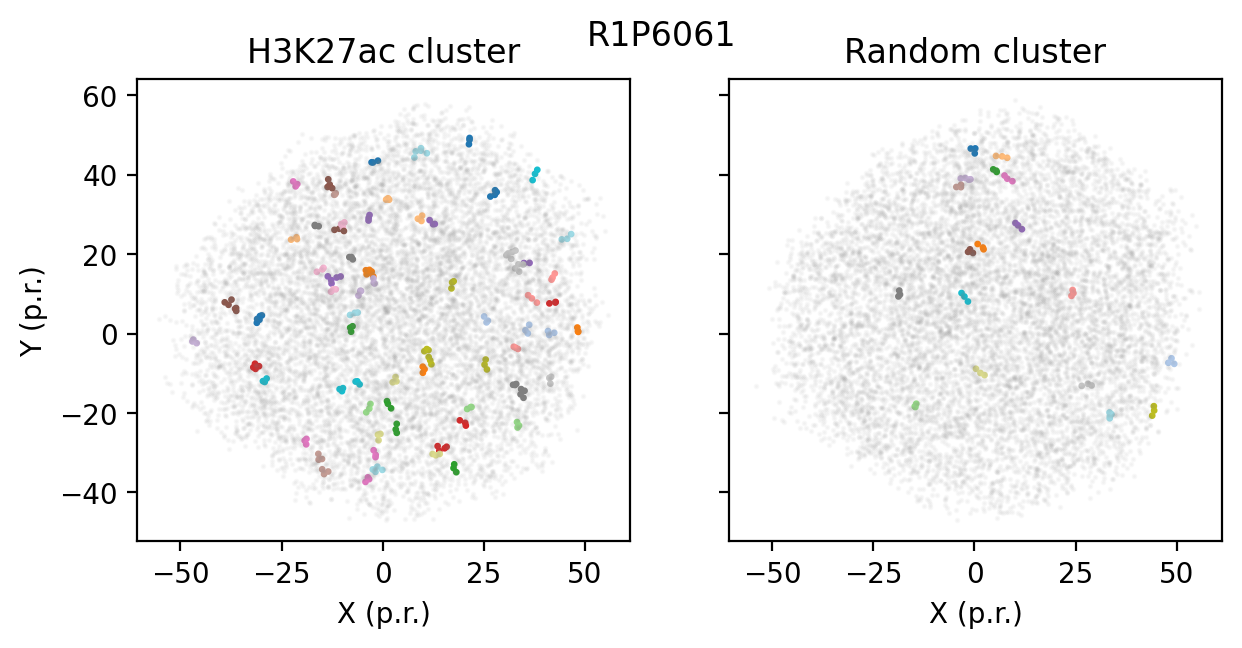

In [44]:
cell = cells[6]
random_ct = cell.tdg.query('ct_random > 0')
ct = cell.tdg.query('ct > 0')

# scatter plot, color by atac_cluster, remove legend
fig,ax = plt.subplots(figsize=(7,3),ncols=2,nrows=1,sharex=True,sharey=True)
ax[0].scatter(x="x",y="y",data=ct.query('ct_cluster != "-1"'),alpha=1,c=ct.query('ct_cluster != "-1"')["ct_cluster"].values.astype("int"), cmap="tab20",s=2)
ax[0].scatter(x="x",y="y",data=cell.tdg.query('ct_cluster == "-1"').sample(10000),alpha=0.05,c="grey",s=1)
ax[0].set_title("H3K27ac cluster")

ax[1].scatter(x="x",y="y",data=random_ct.query('ct_random_cluster != "-1"'),alpha=1,c=random_ct.query('ct_random_cluster != "-1"')["ct_random_cluster"].values.astype("int"), cmap="tab20",s=2)
ax[1].scatter(x="x",y="y",data=cell.tdg.query('ct_random_cluster == "-1"').sample(10000),alpha=0.05,c="grey",s=1,rasterized=True)
ax[1].set_title("Random cluster")

ax[1].set_xlabel("X (p.r.)")
ax[0].set_xlabel("X (p.r.)")
ax[0].set_ylabel("Y (p.r.)")

plt.suptitle(cell.cellname)
plt.savefig("figures/H3K27accluster_example.pdf", bbox_inches='tight')

## Create Object

In [2]:
metadata = pd.read_csv('../1_createobj_embedding/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2]
metadata = metadata.query('celltype not in ["Inh_Unknown1","Inh_Unknown2","Ex_Unknown1","Ex_Unknown2"]').reset_index(drop=True)

In [3]:
tss = pd.read_table("./tss.bed",header=None)
tss.iloc[:,:3].to_csv("tss3.bed",sep="\t",header=None,index=False)

In [4]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", type="allelic_resolved",
                      column_name="atac",keep_3prime=True)
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz", type="allelic_resolved",
                      column_name="ct" ,keep_3prime=True)
    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=5,cluster_name = "atac_cluster",random_seed=42)
    cell.calc_3D_cluster(query = "ct > 0", eps = 1.7, min_samples=3,cluster_name = "ct_cluster",random_seed=42)
    cell.add_bed_data(
        path=f"./tss3.bed",
        column_name="tss",keep_3prime=False,
        type="all"
    )
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

    cell.tdg["atac_3dcluster_particle"] = cell.tdg["atac_cluster"].apply(lambda x: 1 if x != "-1" else 0)
    cell.tdg["ct_3dcluster_particle"] = cell.tdg["ct_cluster"].apply(lambda x: 1 if x != "-1" else 0)
    cell.subset(query = 'atac > 0 or ct > 0 or tss > 0',in_place=True)
    cell.add_feature_in_radius(feature="atac_3dcluster_particle",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="ct_3dcluster_particle",radius=2,type="sum",if_self=True)
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=200) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 2736/2736 [05:36<00:00,  8.13it/s]


In [5]:
genes = pd.concat(
    [
        pd.read_table("./housekeeping_genes.txt",sep="\t",header=None),
        pd.read_table("./celltype_specific_genes.txt",sep="\t",header=None)
    ]
)
genes.columns = ["chrom","start","end","gene","type"]
genes["pos"] = genes["start"] // 5000 * 5000#).astype("int")
genes = genes.dropna()
genes["pos"] = genes["pos"].astype("int")
genes = genes[["chrom","pos","type"]].drop_duplicates()

genesa = genes.copy()
genesa["chrom"] = genes["chrom"] + "a"
genesb = genes.copy()
genesb["chrom"] = genes["chrom"] + "b"

genes = pd.concat([genesa,genesb])

gene_list_dict = genes.groupby("type").apply(lambda x: x[["chrom","pos"]].values.tolist()).to_dict()

In [6]:
mat_cells = []

def process_cell(cell):
    cell_res = []
    celltypes = []
    for celltype in gene_list_dict.keys():
        temp_tdg = cell.get_data().query('tss > 0').copy()
        temp_genes = pd.DataFrame(gene_list_dict[celltype]).iloc[:,0:2].rename(columns={0:"chrom",1:"pos"})
        temp_genes.drop_duplicates(inplace=True)

        temp_genes["count"] = 1

        merge_df = temp_tdg.merge(temp_genes,on=["chrom","pos"],how="left")
        merge_df = merge_df.fillna(0)
        counts = np.array([
            merge_df.query('count > 0 and atac_3dcluster_particle_sum_in_radius_2 > 4').shape[0],
            merge_df.query('count == 0 and atac_3dcluster_particle_sum_in_radius_2 > 4').shape[0],
            merge_df.query('count > 0 and atac_3dcluster_particle_sum_in_radius_2 <= 4').shape[0],
            merge_df.query('count == 0 and atac_3dcluster_particle_sum_in_radius_2 <= 4').shape[0]
        ])
        
        celltypes.append(celltype)
        cell_res.append(counts)
    cell_res_df = pd.DataFrame(cell_res,columns=["feature_in_cluster","not_feature_in_cluster","feature_not_in_cluster","not_feature_not_in_cluster"])
    cell_res_df["celltype_geneset"] = celltypes
    cell_res_df["cellname"] = cell.cellname
    return cell_res_df

with concurrent.futures.ProcessPoolExecutor(128) as executor:
    results = list(tqdm.tqdm(executor.map(process_cell, cells), total=len(cells)))
    mat_cells.extend(results)


100%|██████████| 2736/2736 [04:05<00:00, 11.15it/s]


In [7]:
cluster_df = pd.read_table("./cell_cluster.tsv")
cluster_df.columns = ["cellname","type"]
allcells_genesets = pd.concat(mat_cells,axis=0).merge(cluster_df,on="cellname").groupby(["type","celltype_geneset"]).sum().drop(columns="cellname")
allcells_genesets["oddsratio"], allcells_genesets["pvalue"] = zip(*allcells_genesets.apply(lambda x: fisher_exact([[x["feature_in_cluster"],x["not_feature_in_cluster"]],[x["feature_not_in_cluster"],x["not_feature_not_in_cluster"]]],alternative="greater"),axis=1))
allcells_genesets["nlog10pv"] = -np.log10(allcells_genesets["pvalue"])
allcells_genesets["log2OR"] = np.log2(allcells_genesets["oddsratio"]+1)

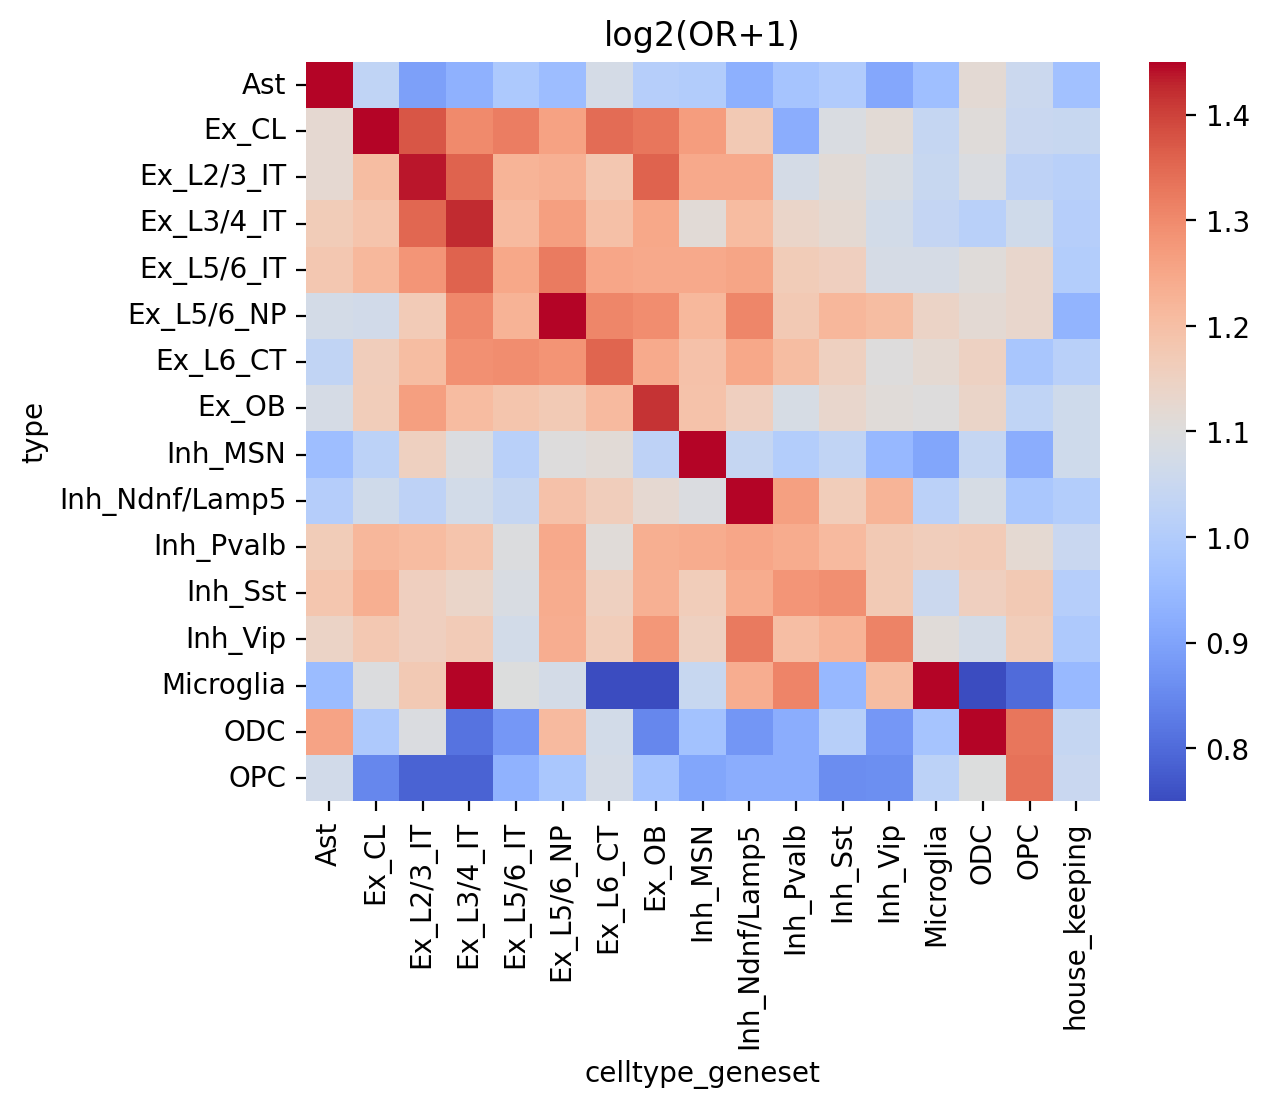

In [17]:
%config InlineBackend.figure_format = 'retina'
mat = allcells_genesets["log2OR"].reset_index().pivot(index="type",columns="celltype_geneset",values="log2OR")
pmat = mat
sns.heatmap(pmat,cmap="coolwarm",center = 1.1,vmin=0.75,vmax=1.45)

plt.title("log2(OR+1)")
# save to pdf 
plt.savefig("figures/ATAC_gene_enrichment.pdf",bbox_inches="tight")


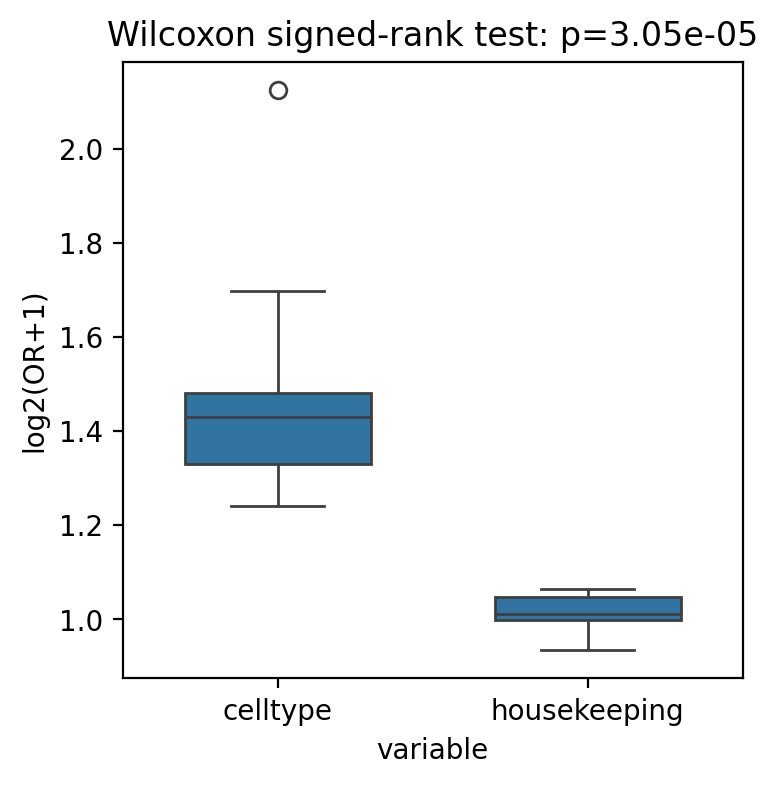

In [18]:
pmat = mat
# drop column housekeeping
OR_celltypespecific = np.diag(pmat.drop(columns="house_keeping"))
OR_housekeeping = pmat[["house_keeping"]].values.flatten()

# boxplot 
plt.figure(figsize=(4,4))
sns.boxplot(x="variable",y="value",data=pd.melt(pd.DataFrame({"celltype":OR_celltypespecific,"housekeeping":OR_housekeeping})),width=0.6)
# pvalue paired wilcoxon test
_,p = stats.wilcoxon(OR_celltypespecific,OR_housekeeping)
plt.title(f"Wilcoxon rank-sum test: p={p:.2e}")
plt.ylabel("log2(OR+1)")
plt.savefig("figures/ATAC_OR_boxplot.pdf",bbox_inches="tight")

In [19]:
mat_cells = []

def process_cell(cell):
    cell_res = []
    celltypes = []
    for celltype in gene_list_dict.keys():
        temp_tdg = cell.get_data().query('tss > 0').copy()
        temp_genes = pd.DataFrame(gene_list_dict[celltype]).iloc[:,0:2].rename(columns={0:"chrom",1:"pos"})
        temp_genes.drop_duplicates(inplace=True)

        temp_genes["count"] = 1

        merge_df = temp_tdg.merge(temp_genes,on=["chrom","pos"],how="left")
        merge_df = merge_df.fillna(0)
        counts = np.array([
            merge_df.query('count > 0 and ct_3dcluster_particle_sum_in_radius_2 > 2').shape[0],
            merge_df.query('count == 0 and ct_3dcluster_particle_sum_in_radius_2 > 2').shape[0],
            merge_df.query('count > 0 and ct_3dcluster_particle_sum_in_radius_2 <= 2').shape[0],
            merge_df.query('count == 0 and ct_3dcluster_particle_sum_in_radius_2 <= 2').shape[0]
        ])
        
        celltypes.append(celltype)
        cell_res.append(counts)
    cell_res_df = pd.DataFrame(cell_res,columns=["feature_in_cluster","not_feature_in_cluster","feature_not_in_cluster","not_feature_not_in_cluster"])
    cell_res_df["celltype_geneset"] = celltypes
    cell_res_df["cellname"] = cell.cellname
    return cell_res_df

with concurrent.futures.ProcessPoolExecutor(128) as executor:
    results = list(tqdm.tqdm(executor.map(process_cell, cells), total=len(cells)))
    mat_cells.extend(results)


100%|██████████| 2736/2736 [03:25<00:00, 13.33it/s]


In [20]:
cluster_df = pd.read_table("./cell_cluster.tsv")
cluster_df.columns = ["cellname","type"]
allcells_genesets = pd.concat(mat_cells,axis=0).merge(cluster_df,on="cellname").groupby(["type","celltype_geneset"]).sum().drop(columns="cellname")
allcells_genesets["oddsratio"], allcells_genesets["pvalue"] = zip(*allcells_genesets.apply(lambda x: fisher_exact([[x["feature_in_cluster"],x["not_feature_in_cluster"]],[x["feature_not_in_cluster"],x["not_feature_not_in_cluster"]]],alternative="greater"),axis=1))
allcells_genesets["nlog10pv"] = -np.log10(allcells_genesets["pvalue"])
allcells_genesets["log2OR"] = np.log2(allcells_genesets["oddsratio"]+1)

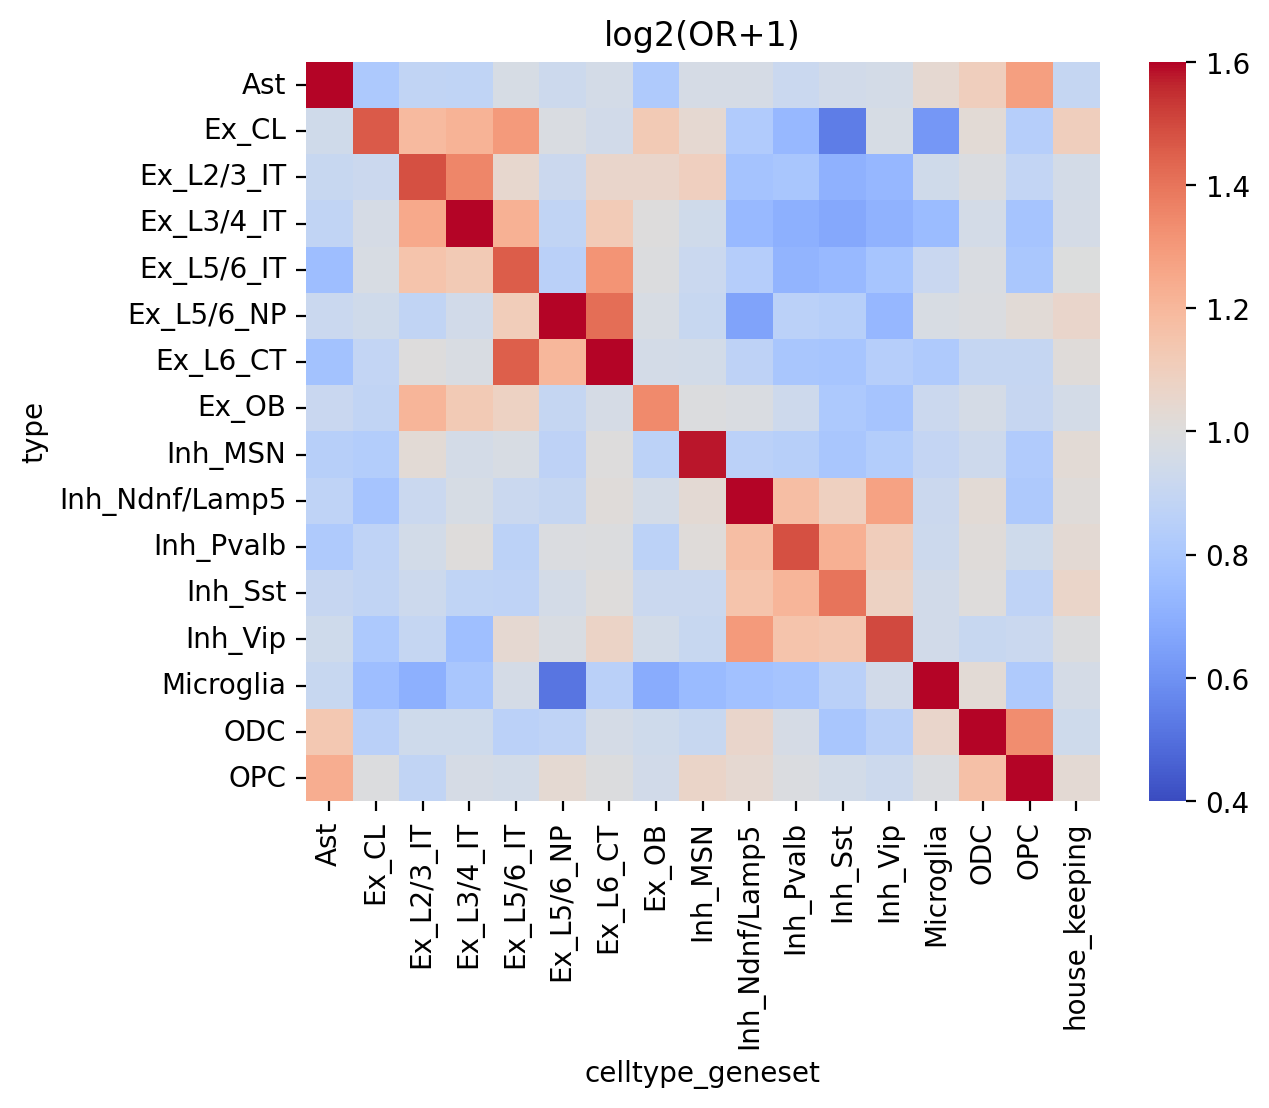

In [21]:
%config InlineBackend.figure_format = 'retina'
mat = allcells_genesets["log2OR"].reset_index().pivot(index="type",columns="celltype_geneset",values="log2OR")
pmat = mat
sns.heatmap(pmat,cmap="coolwarm",center=1,vmin=0.4,vmax=1.6)
#sns.heatmap(pmat,cmap="coolwarm",center=1.05,vmin=0.75,vmax=1.35)

plt.title("log2(OR+1)")
# save to pdf 
plt.savefig("figures/H3K27ac_gene_enrichment.pdf",bbox_inches="tight")


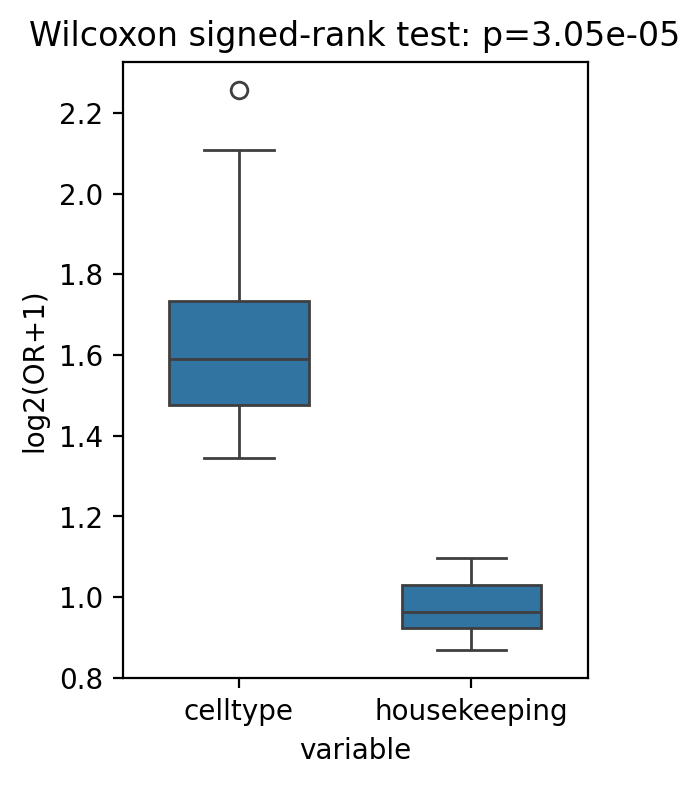

In [14]:
pmat = mat
# drop column housekeeping
OR_celltypespecific = np.diag(pmat.drop(columns="house_keeping"))
OR_housekeeping = pmat[["house_keeping"]].values.flatten()

# boxplot 
plt.figure(figsize=(3,4))
sns.boxplot(x="variable",y="value",data=pd.melt(pd.DataFrame({"celltype":OR_celltypespecific,"housekeeping":OR_housekeeping})),width=0.6)
# pvalue paired wilcoxon test
_,p = stats.wilcoxon(OR_celltypespecific,OR_housekeeping)
plt.title(f"Wilcoxon signed-rank test: p={p:.2e}")
plt.ylabel("log2(OR+1)")
plt.savefig("figures/H3K27ac_OR_boxplot.pdf",bbox_inches="tight")
